In [60]:
import pandas as pd
from IPython.display import display
import PIL.Image
import requests
import random
import os
from requests import get
from IPython.core.display import Image as iPyim, display
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from threading import Thread
from multiprocessing.pool import ThreadPool

In [61]:
df = pd.read_csv('./dataset/faceScrub/facescrub_actors.txt', '	')

In [62]:
df.head()
df.iloc[700].url

'http://www.ramascreen.com/wp-content/uploads/Adam-Sandler.jpg'

In [63]:
image_url = df.iloc[17806]
#Image(filename=df[])
image_url

name                                           Dustin Hoffman
image_id                                                33671
face_id                                                 17963
url         http://25.media.tumblr.com/fa520858c7d4580e396...
bbox                                          122,156,449,483
sha256      094e539978dfbd4fc8a1a667b662e410d77636b5c2ed1e...
Name: 17806, dtype: object

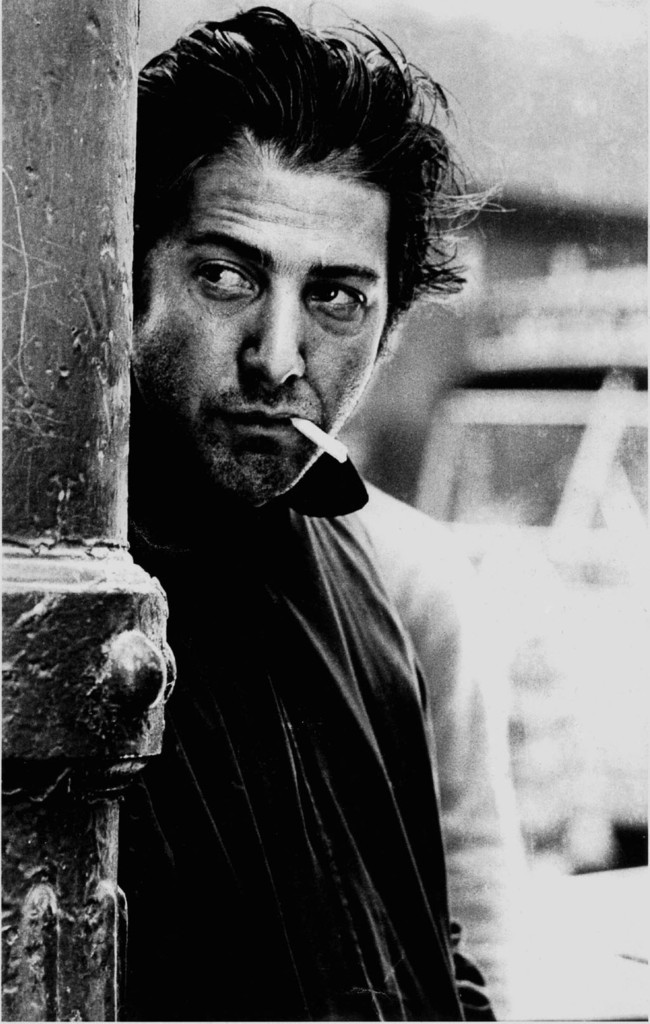

In [64]:
path = image_url.url

display(iPyim(path))


In [65]:
the_image = iPyim(path)

In [66]:
image_url.bbox

'122,156,449,483'

In [93]:
def process_sub_batch(batch_indexes):
    image_batch = []
    success = 0
    failed = 0

    for i, index in enumerate(batch_indexes[0]):
        index = int(index)
        search_index = index
        found = False
        while not found:
            cur_image = df.iloc[search_index]
            split_box = [int(x) for x in cur_image.bbox.split(',')]
            url = df.iloc[search_index].url
            downloaded_img = download_and_crop(url, 'temp_file.jpg', split_box)
            if downloaded_img[0]:
                success += 1
                image_batch.append(downloaded_img)
                if search_index != index:
#                     print("index", i)
#                     print(batch_indexes)
#                     print("Number of indexes", len(batch_indexes))
                    batch_indexes[0][i] = search_index
                found = True
#                 print('Batch results: Retrieval Success. 200:{} 404:{}'.format(success, failed))
            else:
                failed += 1
#                 print('Batch results: Retrieval Failed. 200:{} 404:{}'.format(success, failed))
                search_index = random.randint(0, len(df))
                
    return image_batch

In [68]:
def get_img_cache(batch_data):
    cache_folder = './dataset/'
    filename = cache_folder+'{}-{}.cache'.format(batch[0], batch[-1])
    
    if not os.path.exists(filename):
        print("Downloading Batch", end='\r')
        cur_
        save_img_data(batch_data)
    else:
        print("Saving Batch", end='\r')
        cur_processed_batch = np.load(filename)
    
    return cur_processed_batch

In [69]:
def process_batch_multithread(batch_indexes):
    threads = []
    image_batch = []
    success = 0
    failed = 0
    buckets = 10
    partition = len(batch_indexes) // buckets
    pool = multiprocessing.pool.ThreadPool(processes=concurrent)
    
#     buckets = len(batch_indexes) // 10
#     batch1 = Thread(target=process_sub_batch, args=(batch_indexes[0:buckets]))
#     batch2 = Thread(target=process_sub_batch, args=(batch_indexes[buckets+1:2*buckets]))
#     batch2 = Thread(target=process_sub_batch, args=(batch_indexes[2*buckets+1:3*buckets]))

    for i in range(buckets):
        if i is not 0 or i is not (len(batch_indexes)-1):
#             print(batch_indexes[i*partition+1:(i+1)*partition])
            threads.append(Thread(target=process_sub_batch, args=[[batch_indexes[i*partition+1:(i+1)*partition]]]))
        elif i == 0:
#             print(batch_indexes[0:partition])
            threads.append(Thread(target=process_sub_batch, args=[[batch_indexes[0:partition]]]))
        elif i == (len(batch_indexes)-1):
#             print(batch_indexes[i*partition+1:])
            threads.append(Thread(target=process_sub_batch, args=[[batch_indexes[i*partition+1:]]]))
    
    for thread in threads:
        thread.start()
    
    for thread in threads:
        thread.join()
                                  
    return threads

In [70]:
def download_and_crop(url, temp_filename, split_box):
    try:
        with open(temp_filename, 'wb') as file:
            response = get(url)
            file.write(response.content)
        img = PIL.Image.open(temp_filename)
        # Process Image
        cropped = img.crop((split_box[0], split_box[1], split_box[2], split_box[3]))
        cropped.thumbnail((250, 250), PIL.Image.ANTIALIAS)

        img_ary = np.array(cropped)
        # Rescale -1 to 1
        pretty_image = np.interp(img_ary, (img_ary.min(), img_ary.max()), (-1, +1))
#         print('Retrieval Success.')
        return (1, pretty_image)
    except:
#         print('Retrieval Failed')      
        return (0,0)


In [71]:
def save_img_data(img_data, filename):
    np.savetxt(filename, img_data, fmt='%.18e')

In [72]:
250**2

62500

In [73]:
# Define hyper parameters
img_rows = 250
img_cols = 250
channels = 3
img_shape = (img_rows, img_cols, channels)

latent_dims = 100
epochs = 3000
batch_size = 128
sample_interval = 50

In [74]:
# Sample Dataset
from keras.datasets import mnist
(reX_train, _), (_, _) = mnist.load_data()

In [75]:
reX_train[0]
reX_train.shape[0]

60000

In [76]:
# Prepare Dataset

X_train, X_test, y_train, y_test = train_test_split(df, df[['face_id']], test_size=0.33)

In [77]:
X_train.head()

,name,image_id,face_id,url,bbox,sha256
46763,Paul Bettany,90445,47141,http://singlegalz.files.wordpress.com/2011/05/...,"455,142,689,376",fe12b48c3c08b8aabe2f9313181a32ce7364af4338a434...
45756,Orlando Bloom,88763,46131,http://www.desktopdome.com/wp-content/uploads/...,"764,359,1911,1506",abd07ef2d7711d3cde7e1bd6e03105f6f237281c939056...
9191,Burt Reynolds,16809,9275,http://3.bp.blogspot.com/_04kZGR_ltmE/SuoFEgDs...,"273,267,496,490",e35eeacc0e73b520e0377a9db40f5053ee501b6a9bf8cd...
5156,Ben McKenzie,9235,5206,http://assets-s3.usmagazine.com/uploads/assets...,"83,89,249,255",aa5a29c5e6d7ce838d02804e7de716e9517b042393bf23...
48768,Rob Schneider,94876,49164,http://galeri5.uludagsozluk.com/1/rob-schneide...,"113,134,388,409",7385ae7f4b4e0a8b9c1d2b87e75afa84466d8d39b7e171...


In [78]:
# Adversarial Ground Truth
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [79]:
# Build Generator Function
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dims))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

#     model.summary()
    noise = Input(shape=(latent_dims,))
    img = model(noise)

    return Model(noise, img)

In [80]:
# Define Discriminator
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    
#     model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(inputs=img, outputs=validity)

In [81]:
# Compile Discriminator
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()

In [82]:
# Build Generator
generator = build_generator()

In [83]:
# Define Combined Model
def build_combined():
    # The generator takes noise as input and generates imgs
    z = Input(shape=(latent_dims,))
    img = generator(z)

    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = discriminator(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy',optimizer=optimizer)
    return combined

In [84]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dims))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    
    plt.show()
    plt.close()

In [85]:
combined = build_combined()
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [86]:
# Create epochs
if not os.path.exists('epoch_img_index.cache'):
    epoch_imgs = []

    for _ in range(epochs):
        epoch_imgs.append(np.random.randint(0, len(X_train), batch_size, dtype=np.int))

    np.savetxt('epoch_img_index.cache', epoch_imgs)
else:
    epoch_imgs = np.loadtxt('epoch_img_index.cache')
#Don't use scientific notation for index values!
np.set_printoptions(suppress=True)

In [94]:
# img_cache(epoch_imgs[0])

batch = process_batch_multithread(epoch_imgs[0])
batch

[<Thread(Thread-65, stopped 140586141079296)>,
 <Thread(Thread-66, stopped 140586115901184)>,
 <Thread(Thread-67, stopped 140586124293888)>,
 <Thread(Thread-68, stopped 140586525120256)>,
 <Thread(Thread-69, stopped 140586548983552)>,
 <Thread(Thread-70, stopped 140586516727552)>,
 <Thread(Thread-71, stopped 140586508334848)>,
 <Thread(Thread-72, stopped 140586150786816)>,
 <Thread(Thread-73, stopped 140586132686592)>,
 <Thread(Thread-74, stopped 140586107508480)>]

In [88]:
# def df_purge():
#     purge_indexes = []
#     for index in range(len(df)):
#         url = df.iloc[index].url
#         try:
#             response = get(url)
#         except:
#             purge_indexes.append(index)
#     df.drop(purge_indexes)

# print(len(df))
# df_purge()
# print(len(df))

In [89]:
batches = process_batch_multithread(epoch_imgs[0])
batches

index 0
Number of indexes 1
index 1
Number of indexes 1
index 0
Number of indexes 1
index 0
Number of indexes 1


Exception in thread Thread-47:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



index 2
Number of indexes 1
index 2
Number of indexes 1


Exception in thread Thread-52:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range

Exception in thread Thread-54:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



index 1
Number of indexes 1


Exception in thread Thread-46:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



index 2
Number of indexes 1
index 1
Number of indexes 1


Exception in thread Thread-50:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range

Exception in thread Thread-53:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



index 3
Number of indexes 1


Exception in thread Thread-48:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



index 2
Number of indexes 1


Exception in thread Thread-49:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



index 3
Number of indexes 1


Exception in thread Thread-45:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



Retrieval Failed
Batch results: Retrieval Failed. 200:3 404:2
index 3
Number of indexes 1


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-9-e46dfb575e55>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



index 1
Number of indexes 1


Exception in thread Thread-51:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-67-d493a7369268>", line 21, in process_sub_batch
    batch_indexes[i] = search_index
IndexError: list assignment index out of range



[<Thread(Thread-45, stopped 140586132686592)>,
 <Thread(Thread-46, stopped 140586107508480)>,
 <Thread(Thread-47, stopped 140586515408640)>,
 <Thread(Thread-48, stopped 140586115901184)>,
 <Thread(Thread-49, stopped 140586548983552)>,
 <Thread(Thread-50, stopped 140586525120256)>,
 <Thread(Thread-51, stopped 140586507015936)>,
 <Thread(Thread-52, stopped 140586150786816)>,
 <Thread(Thread-53, stopped 140586124293888)>,
 <Thread(Thread-54, stopped 140585620993792)>]

In [90]:
for epoch_batch in epoch_imgs:

    # Select a random batch of images
#     idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = get_batch(epoch_batch)
    imgs = download_and_crop(idx)

    noise = np.random.normal(0, 1, (batch_size, latent_dims))

    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # ---------------------
    # Train the discriminator
    # ---------------------

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dims))

    # Train the generator (to have the discriminator label samples as valid)
    g_loss = combined.train_on_batch(noise, valid)
    
#     Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        sample_images(epoch)

NameError: name 'get_batch' is not defined